# All the plots for the MDM paper

In [29]:
import numpy as np
import xarray as xr
from distributed import Client
import dask_jobqueue
import matplotlib.pyplot as plt
import matplotlib as mtplt
import glob
# import netCDF4 as nc
import zarr
import nc_time_axis
import xskillscore as xs
import cartopy as cart
#np.set_printoptions(threshold=np.inf)
import matplotlib.colors as mcolors
import matplotlib.cm as cm
from datetime import datetime, timedelta
import pandas as pd
import random
from scipy.special import erfinv, erf

In [22]:
#
sgp_lat   = 36.607
sgp_lon   = (360-97.487)%360

#36.607322° N and 97.487643° W
########## CONUS ############
#CONUS lat-lon
top       = 50.0 # north lat
left      = -124.7844079+360 # west long
right     = -66.9513812+360 # east long
bottom    =  24.7433195 # south lat
################################
sgp_path     =  '/global/scratch/users/harsha/SGP/'
loc1       = 'SGP/'
locn1      = 'SGP'
#
cesm2_path = '/global/scratch/users/harsha/LENS/cesm2/tasmax/'
cvals_bias = '/global/scratch/users/harsha/LENS/cesm2/cvals/bias/'
cvals_det      = '/global/scratch/users/harsha/LENS/cesm2/cvals/detrended/'
cvals      = '/global/scratch/users/harsha/LENS/cesm2/cvals/'
print(sgp_lat,sgp_lon)
#
pi_year  = 1865
eoc_year = 2085
#
doy  = 211
#
pi_year0  = '1850'
pi_year1  = '1879'
ic_year0  = '2071'
ic_year1  = '2100'

36.607 262.51300000000003


In [15]:
def no_leap_date(day_of_year):
    # Start from the first day of a non-leap year
    start_date = datetime(2021, 1, 1)

    # Calculate the actual date (subtract 1 because January 1st is day 1)
    actual_date = start_date + timedelta(days=day_of_year - 1)

    # Format the date to get 'Month Day'
    return actual_date.strftime('%B %d')
###############################
date = no_leap_date(doy)
date
date0     = 'Jul30'

In [30]:
def gauss_quantile(mean,std,quantile):
    #quantile must be a real number neteoceen 0 and 1
    qvalue = mean + std * np.sqrt(2) * erfinv(2*quantile-1)
    return qvalue

In [3]:
job_extra = ['--qos=cf_lowprio','--account=ac_cumulus'] 
#job_extra =['--qos=lr6_lowprio','--account=ac_cumulus','--constraint=lr6_m192']
#job_extra =['--qos=condo_cumulus_lr6','--account=lr_cumulus','--constraint=lr6_m192']
#job_extra =['--qos=lr_lowprio','--account=ac_cumulus']
cluster = dask_jobqueue.SLURMCluster(queue="cf1", cores=10, walltime='5:00:00', 
                local_directory='/global/scratch/users/harsha/dask_space/', 
                log_directory='/global/scratch/users/harsha/dask_space/', 
                job_extra_directives=job_extra, interface='eth0', memory="192GB") 
client  = Client(cluster) 
cluster.scale_up(3)

/global/home/users/harsha/miniconda3/envs/pyenv/lib/python3.9/site-packages/distributed/node.py:182: UserWarning: Port 8787 is already in use.
Perhaps you already have a cluster running?
Hosting the HTTP server on port 44871 instead
  warnings.warn(


In [4]:
cluster

Dashboard: http://10.0.39.1:44871/status,Workers: 0
Total threads: 0,Total memory: 0 B
Comm: tcp://10.0.39.1:38353,Workers: 0
Dashboard: http://10.0.39.1:44871/status,Total threads: 0
Started: Just now,Total memory: 0 B


### Plot 2

In [23]:
%%time
#
dpi_detpath1      = cvals_det+loc1+'tpi_det'+date0+'_'+pi_year0+'_'+pi_year1+'_loc.zarr'
deoc_detpath1     = cvals_det+loc1+'teoc_det'+date0+'_'+ic_year0+'_'+ic_year1+'_loc.zarr'
dmsc_detpath1     = cvals_det+loc1+'tmsc_det'+date0+'_'+ic_year0+'_'+ic_year1+'_loc.zarr'
dmc_detpath1      = cvals_det+loc1+'tmc_det'+date0+'_'+ic_year0+'_'+ic_year1+'_loc.zarr'
#
tpi_loc1_det     = xr.open_zarr(dpi_detpath1).detrended_tmax
teoc_loc1_det    = xr.open_zarr(deoc_detpath1).detrended_tmax
tmc_loc1_det     = xr.open_zarr(dmc_detpath1).detrended_tmax
tmsc_loc1_det    = xr.open_zarr(dmsc_detpath1).detrended_tmax

CPU times: user 382 ms, sys: 35.1 ms, total: 417 ms
Wall time: 414 ms


In [31]:
%%time
# Get the Gaussian candidate distrubutions for the EOC period.
quants      = np.arange(0.0,1.01,0.01)
#
qeocgauss_loc1_det = gauss_quantile(teoc_loc1_det.mean().values,teoc_loc1_det.std().values,quants)
qeocgauss_loc1_det = xr.DataArray(qeocgauss_loc1_det, coords={'quantile': quants}, dims=["quantile"])
#
qpigauss_loc1_det  = gauss_quantile(tpi_loc1_det.mean().values,tpi_loc1_det.std().values,quants)
qpigauss_loc1_det  = xr.DataArray(qpigauss_loc1_det, coords={'quantile': quants}, dims=["quantile"])

CPU times: user 608 ms, sys: 45.5 ms, total: 653 ms
Wall time: 839 ms


### Plot 6

In [41]:
average_mdm_mae  = xr.open_zarr(cvals_det + 'mdm_mae_avg100pairs.zarr').tmax
average_sqdm_mae = xr.open_zarr(cvals_det + 'sqdm_mae_avg100pairs.zarr').tmax
average_sqdm_mae 

<xarray.DataArray 'tmax' (quantile: 30)>
dask.array<open_dataset-7ea99a5c5158530ca8cf3be4879f4dcctmax, shape=(30,), dtype=float64, chunksize=(30,), chunktype=numpy.ndarray>
Coordinates:
  * quantile  (quantile) float64 0.0 0.03448 0.06897 0.1034 ... 0.931 0.9655 1.0

In [40]:
%%time
cmip6_average_mdm_mae  = xr.open_zarr(cvals_det + 'cmip6_mdm_mae_avg306pairs.zarr').tmax
cmip6_average_sqdm_mae = xr.open_zarr(cvals_det + 'cmip6_sqdm_mae_avg306pairs.zarr').tmax
cmip6_average_sqdm_mae

CPU times: user 65.1 ms, sys: 18.4 ms, total: 83.5 ms
Wall time: 77.4 ms


<xarray.DataArray 'tmax' (quantile: 30)>
dask.array<open_dataset-cee556cca931529702544ffbda8fa8b0tmax, shape=(30,), dtype=float64, chunksize=(30,), chunktype=numpy.ndarray>
Coordinates:
  * quantile  (quantile) float64 0.0 0.03448 0.06897 0.1034 ... 0.931 0.9655 1.0

In [39]:
%%time
qgmc_gmaepath     = cvals+'qgmc_gmae'+'_'+ic_year0+'_'+ic_year1+'.zarr'
qgmsc_gmaepath    = cvals+'qgmsc_gmae'+'_'+ic_year0+'_'+ic_year1+'.zarr'
qgmc_gmae     = xr.open_zarr(qgmc_gmaepath).Error
qgmsc_gmae    = xr.open_zarr(qgmsc_gmaepath).Error
qgmsc_gmae 

CPU times: user 197 ms, sys: 28.1 ms, total: 225 ms
Wall time: 241 ms


<xarray.DataArray 'Error' (quantile: 101)>
dask.array<open_dataset-c7ed84a8ebd64f9037a2553cc81c71c0Error, shape=(101,), dtype=float64, chunksize=(101,), chunktype=numpy.ndarray>
Coordinates:
    member    int64 ...
  * quantile  (quantile) float64 0.0 0.01 0.02 0.03 0.04 ... 0.97 0.98 0.99 1.0
    year      int64 ...
    ym        int64 ...

CPU times: user 1.11 s, sys: 68.2 ms, total: 1.18 s
Wall time: 1.54 s


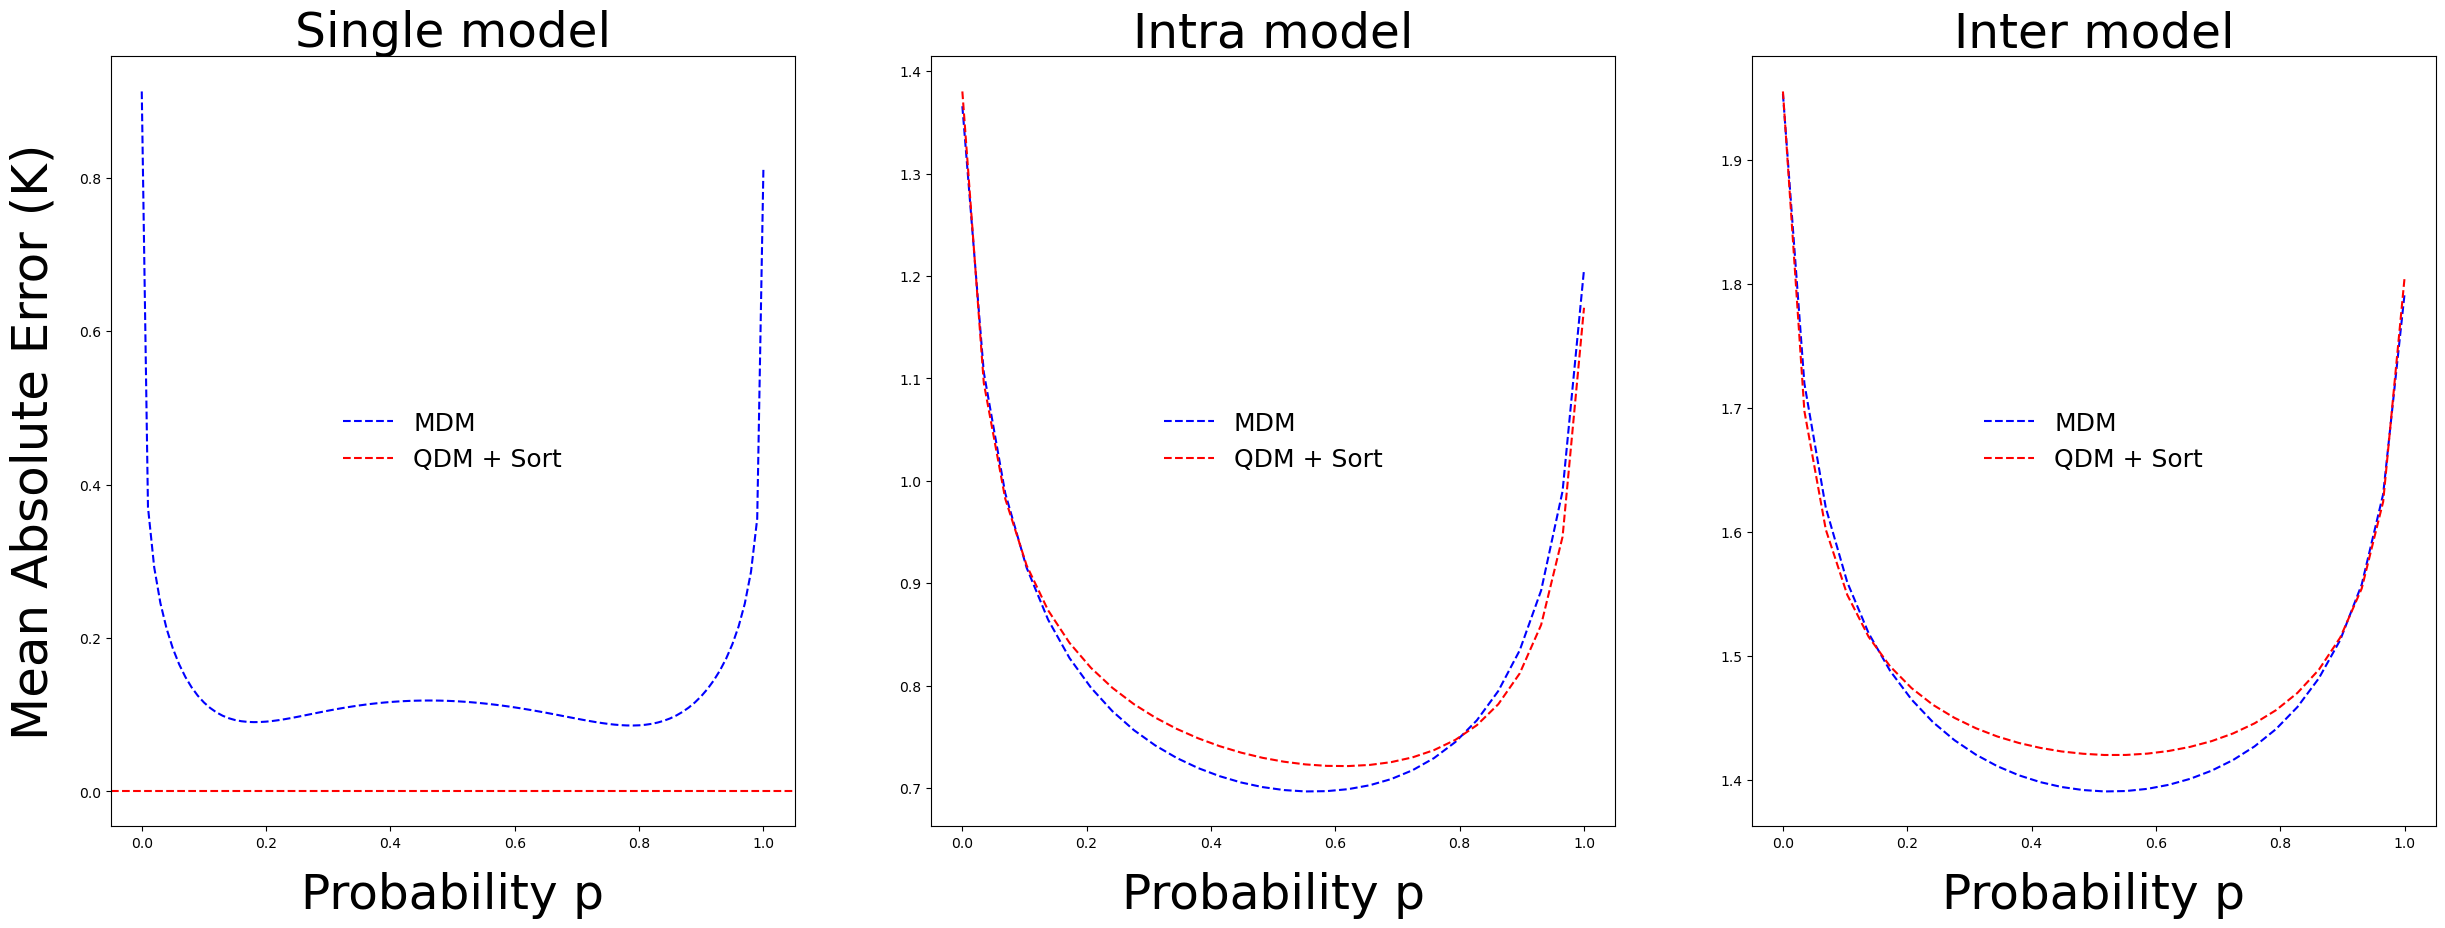

In [48]:
%%time
# Plot the 3 figures as a 3-panel plot
# Setting up the figure and subplots
quants30        = np.linspace(0,1.0,30)
fig, axs = plt.subplots(1, 3, figsize=(30, 10)) # 3 plots - side by side

#Plot for single model
axs[0].plot(quants,qgmsc_gmae,'b--', label ='MDM')
axs[0].axhline(y=0,color='r', linestyle='--',label='QDM + Sort',)
axs[0].set_ylabel('Mean Absolute Error (K)',fontweight=500,fontsize=36,labelpad=15)
axs[0].set_xlabel('Probability p',fontweight=500,fontsize=35,labelpad=15)
axs[0].set_title('Single model',fontweight=500,fontsize=35)
axs[0].legend(loc='center',prop={'size': 18},frameon= False)

#Intra model error
axs[1].plot(quants30,average_mdm_mae ,'b--', label ='MDM')
axs[1].plot(quants30,average_sqdm_mae ,'r--',label='QDM + Sort')
axs[1].set_xlabel('Probability p',fontweight=500,fontsize=35,labelpad=15)
axs[1].set_title('Intra model',fontweight=500,fontsize=35)
axs[1].legend(loc='center',prop={'size': 18},frameon= False)

#Inter model error
axs[2].plot(quants30,cmip6_average_mdm_mae ,'b--', label ='MDM')
axs[2].plot(quants30,cmip6_average_sqdm_mae ,'r--',label='QDM + Sort')
axs[2].set_xlabel('Probability p',fontweight=500,fontsize=35,labelpad=15)
axs[2].set_title('Inter model',fontweight=500,fontsize=35)
axs[2].legend(loc='center',prop={'size': 18},frameon=False)